In [1]:
# import necessary modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft , rfft, irfft , fftfreq
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
from classy import Class
from scipy.optimize import fsolve
from scipy.special import gamma
from scipy.special import hyp2f1
from scipy import interpolate
import sys,os
from time import time
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy import special
from scipy.special import factorial
import math

In [3]:
############################################
z_pk = 0.61
common_settings = {# fixed LambdaCDM parameters
                   'A_s':2.089e-9,
                   'n_s':0.9649,
                   'tau_reio':0.052,
                   'omega_b':0.02237,
                   #'omega_cdm':0.12,
                   'omega_cdm':1e-15,
                   'h':0.6736,
                   'YHe':0.2425,
#                     'N_eff':3.046,
                    'N_ur':2.0328,
                    'N_ncdm':1,
                    'm_ncdm':0.06,
                    'omega_dmeff': 0.12,
                    'npow_dmeff': -2,
                    'sigma_dmeff': 1e-32,
                    'm_dmeff': 1.0,
                    'dmeff_target': 'hydrogen', 'Vrel_dmeff': 0., 
                   # other output and precision parameters
#                    'P_k_max_1/Mpc':100.0,
                   'z_pk':z_pk}  

M = Class()
M.set(common_settings)
#let's first take a look at the one-loop power spectrum for matter without IR resummation
M.set({ 'output':'mPk',
       'non linear':'PT',
       'IR resummation':'No',
       'Bias tracers':'No'
       ,'cb':'No'
      })
M.compute()
#now we compute all the spectra including IR resummation, RSD, 
#and AP generated for a fiducial cosmology with $\Omega_m=0.31$ 
M1 = Class()
M1.set(common_settings)
M1.set({'output':'mPk',
        'non linear':'PT',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'No',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })
M1.compute()

In [3]:
# aesthetic definitions for the plots
font = {'size'   : 20, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='small'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [4]:
#print(pk_IG2)

NameError: name 'pk_IG2' is not defined

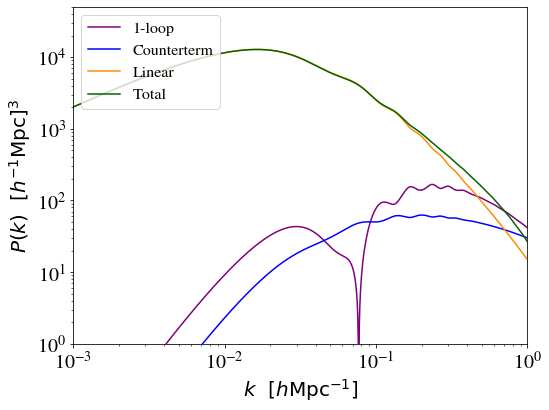

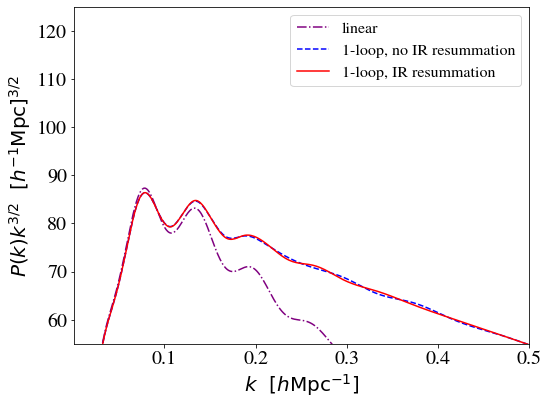

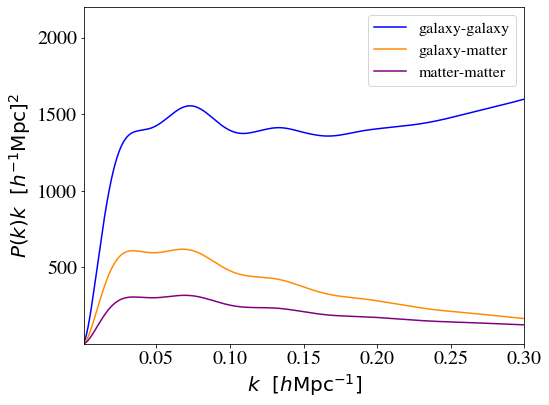

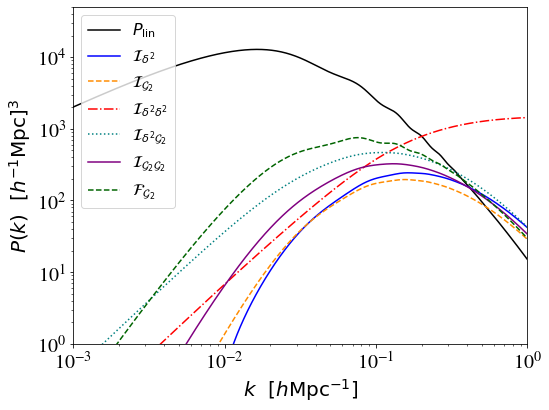

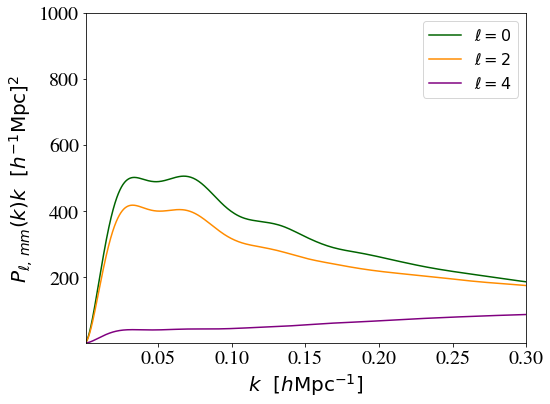

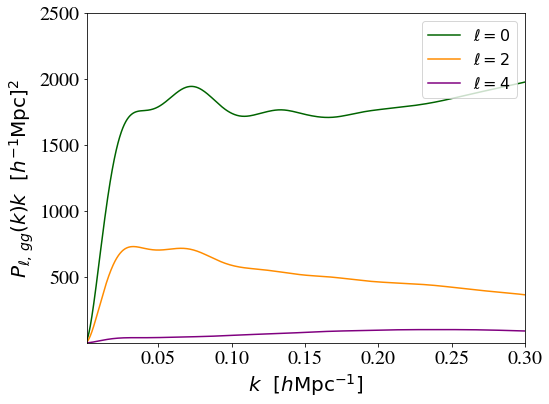

In [5]:
#############################################
#
# extract spectra and plot them
#
#############################################

h = M.h()
fz = M.scale_independent_growth_factor_f(z_pk)
kvec = np.logspace(-3,np.log10(3),1000) # array of kvec in h/Mpc
twopi = 2.*math.pi
khvec = kvec*h # array of kvec in 1/Mpc
#
# Create figures
#
fig_Pk, ax_Pk = plt.subplots()
fig_Pkir, ax_Pkir = plt.subplots()
fig_Pkgg, ax_Pkgg = plt.subplots()
fig_Pkgm, ax_Pkgm = plt.subplots()
fig_Pkmz, ax_Pkmz = plt.subplots()
fig_Pkgz, ax_Pkgz = plt.subplots()


##### NUISANCE PARAMETERS ####
b1 = 2.0
cs = 1. # in units [Mpc/h]^2
b2 = -1.
bG2 = 0.1
bGamma3 = -0.1
Pshot = 5e3 # in units [Mpc/h]^3
cs0 = 5. # in units [Mpc/h]^2
cs2 = 15. # in units [Mpc/h]^2
cs4 = -5. # in units [Mpc/h]^2
b4 = 100. # in units [Mpc/h]^4
##############################

## Initialize the convenience functions pk_mm_real, pk_gg_l0 etc.
M.initialize_output(khvec, z_pk, len(khvec))
M1.initialize_output(khvec, z_pk, len(khvec))

## COMPUTE SPECTRA #######
# NB: these are fast, since no quantities are recomputed

# basic real space matter power spectrum without IR resummation
pk_full = M.pk_mm_real(cs)

# real space matter power spectrum
pk_full_ir = M1.pk_mm_real(cs)

# real space galaxy-galaxy power spectrum 
pk_gg = M1.pk_gg_real(b1, b2, bG2, bGamma3, cs, cs0, Pshot)

# real space galaxy-matter power spectrum 
pk_gm = M1.pk_gm_real(b1, b2, bG2, bGamma3, cs, cs0)

# dark matter redshift space monopole/quadrupole/hexadecapole
pk_m0 = M1.pk_mm_l0(cs0)
pk_m2 = M1.pk_mm_l2(cs2)
pk_m4 = M1.pk_mm_l4(cs4)

# galaxy redshift space monopole/quadrupole/hexadecapole
pk_g0 = M1.pk_gg_l0(b1, b2, bG2, bGamma3, cs0, Pshot, b4)
pk_g2 = M1.pk_gg_l2(b1, b2, bG2, bGamma3, cs2, b4)
pk_g4 = M1.pk_gg_l4(b1, b2, bG2, bGamma3, cs4, b4)
###########################

# Compute additional quantities (which don't have inbuilt wrappers)

# linear theory matter power spectrum
pk_lin = np.asarray([M1.pk_lin(kh,z_pk)*h**3. for kh in khvec])

# load all non-linear components
M1_mult = M1.get_pk_mult(khvec, z_pk, len(khvec))
M_mult = M.get_pk_mult(khvec, z_pk, len(khvec))

# separate contributions of the matter-matter power spectrum
pk_tree = M_mult[14]*h**3.
pk_loop = M_mult[0]*h**3.
pk_ctr = 2*M_mult[10]*h
# separate contributions of the galaxy-galaxy power spectrum
pk_Id2 = (M1_mult[2])*h**3.
pk_IG2 = (M1_mult[3])*h**3. 
#pk_IG2 = np.zeros(len(M1_mult[3]))
pk_Id2d2 = (M1_mult[1])*h**3. 
pk_IG2G2 = (M1_mult[5])*h**3. 
pk_Id2G2 = (M1_mult[4])*h**3. 
pk_FG2 = (M1_mult[6])*h**3.
    
ax_Pk.loglog(kvec,np.array(np.abs(pk_loop)),color='purple',linestyle='-',label='1-loop')
ax_Pk.loglog(kvec,np.array(np.abs(pk_ctr)),color='b',linestyle='-',label='Counterterm')
ax_Pk.loglog(kvec,np.array(pk_tree),color='darkorange',linestyle='-',label='Linear')
ax_Pk.loglog(kvec,np.array(pk_full),color='darkgreen',linestyle='-',label='Total')

ax_Pkir.plot(kvec,np.array(pk_lin)*kvec**1.5,color='purple',linestyle='-.',label='linear')
ax_Pkir.plot(kvec,np.array(pk_full)*kvec**1.5,color='b',linestyle='--',label='1-loop, no IR resummation')
ax_Pkir.plot(kvec,np.array(pk_full_ir)*kvec**1.5,color='r',linestyle='-',label='1-loop, IR resummation')

ax_Pkgg.plot(kvec,np.array(pk_gg)*kvec,color='b',linestyle='-',label='galaxy-galaxy')
ax_Pkgg.plot(kvec,np.array(pk_gm)*kvec,color='darkorange',linestyle='-',label='galaxy-matter')
ax_Pkgg.plot(kvec,np.array(pk_full_ir)*kvec,color='purple',linestyle='-',label='matter-matter')

ax_Pkgm.loglog(kvec,np.array(np.abs(pk_lin)),color='k',linestyle='-',label=r'$P_{\rm lin}$')
ax_Pkgm.loglog(kvec,np.array(np.abs(pk_Id2)),color='b',linestyle='-',label=r'${\cal I}_{\delta^2}$')
ax_Pkgm.loglog(kvec,np.array(np.abs(pk_IG2)),color='darkorange',linestyle='--',label=r'${\cal I}_{{\cal G}_2}$')
ax_Pkgm.loglog(kvec,np.array(np.abs(pk_Id2d2)),color='r',linestyle='-.',label=r'${\cal I}_{\delta^2\delta^2}$')
ax_Pkgm.loglog(kvec,np.array(np.abs(pk_Id2G2)),color='teal',linestyle=':',label=r'${\cal I}_{\delta^2{\cal G}_2}$')
ax_Pkgm.loglog(kvec,np.array(np.abs(pk_IG2G2)),color='purple',linestyle='-',label=r'${\cal I}_{{\cal G}_2{\cal G}_2}$')
ax_Pkgm.loglog(kvec,np.array(np.abs(pk_FG2)),color='darkgreen',linestyle='--',label=r'${\cal F}_{{\cal G}_2}$')

ax_Pkmz.plot(kvec,np.array(pk_m0)*kvec,color='darkgreen',linestyle='-',label=r'$\ell = 0$')
ax_Pkmz.plot(kvec,np.array(pk_m2)*kvec,color='darkorange',linestyle='-',label=r'$\ell = 2$')
ax_Pkmz.plot(kvec,np.array(pk_m4)*kvec,color='purple',linestyle='-',label=r'$\ell = 4$')

ax_Pkgz.plot(kvec,np.array(pk_g0)*kvec,color='darkgreen',linestyle='-',label=r'$\ell = 0$')
ax_Pkgz.plot(kvec,np.array(pk_g2)*kvec,color='darkorange',linestyle='-',label=r'$\ell = 2$')
ax_Pkgz.plot(kvec,np.array(pk_g4)*kvec,color='purple',linestyle='-',label=r'$\ell = 4$')


# output of P(k) figures
ax_Pk.set_xlim([1.e-3,1])
ax_Pk.set_ylim([1,5e4])
ax_Pk.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pk.set_ylabel(r'$P(k)\,\,\,\, [h^{-1}\mathrm{Mpc}]^3$')
ax_Pk.legend(fontsize='16',ncol=1,loc='upper left')
fig_Pk.savefig('real_Pk.pdf')
fig_Pk.tight_layout()

ax_Pkir.set_xlim([1.e-3,0.5])
ax_Pkir.set_ylim([55,125])
ax_Pkir.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pkir.set_ylabel(r'$P(k)k^{3/2}\,\,\,\, [h^{-1}\mathrm{Mpc}]^{3/2}$')
ax_Pkir.legend(fontsize='16',ncol=1,loc='upper right')
fig_Pkir.savefig('real_Pk_IR.pdf')
fig_Pkir.tight_layout()

ax_Pkgg.set_xlim([1.e-3,0.3])
ax_Pkgg.set_ylim([1,2200])
ax_Pkgg.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pkgg.set_ylabel(r'$P(k)k\,\,\,\, [h^{-1}\mathrm{Mpc}]^{2}$')
ax_Pkgg.legend(fontsize='16',ncol=1,loc='upper right')
fig_Pkgg.savefig('real_Pkgg.pdf')
fig_Pkgg.tight_layout()

ax_Pkgm.set_xlim([1.e-3,1])
ax_Pkgm.set_ylim([1,5e4])
ax_Pkgm.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pkgm.set_ylabel(r'$P(k)\,\,\,\, [h^{-1}\mathrm{Mpc}]^3$')
ax_Pkgm.legend(fontsize='16',ncol=1,loc='upper left')
fig_Pkgm.savefig('real_Pkgg_breakdown.pdf')
fig_Pkgm.tight_layout()

ax_Pkmz.set_xlim([1.e-3,0.3])
ax_Pkmz.set_ylim([1,1000])
ax_Pkmz.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pkmz.set_ylabel(r'$P_{\ell,\,mm}(k)k\,\,\,\, [h^{-1}\mathrm{Mpc}]^{2}$')
ax_Pkmz.legend(fontsize='16',ncol=1,loc='upper right')
fig_Pkmz.savefig('rsd_Pkmm.pdf')
fig_Pkmz.tight_layout()


ax_Pkgz.set_xlim([1.e-3,0.3])
ax_Pkgz.set_ylim([1,2500])
ax_Pkgz.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pkgz.set_ylabel(r'$P_{\ell,\,gg}(k)k\,\,\,\, [h^{-1}\mathrm{Mpc}]^{2}$')
ax_Pkgz.legend(fontsize='16',ncol=1,loc='upper right')
fig_Pkgz.savefig('rsd_Pkgg.pdf')
fig_Pkgz.tight_layout()


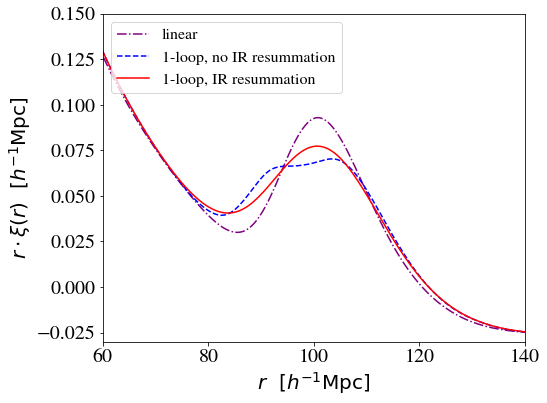

In [5]:
#############################################
#
# extract position space correlation functions
#
#############################################



def J0(r,nu):
    return -1.*np.sin(pi*nu/2.)*r**(-3.-1.*nu)*special.gamma(2+nu)/(2.*pi**2.)
Nmax = 256
bk = -1.1001
kmax = 100.
k0 = 1.e-4
rtab = np.zeros(Nmax)
rmin = 0.01
rmax = 1000.
Delta = log(kmax/k0) / (Nmax - 1)
Delta_r = log(rmax/rmin) / (Nmax - 1)

Pdiscrin0 = np.zeros(Nmax);
Pdiscrin1 = np.zeros(Nmax);
Pdiscrin2 = np.zeros(Nmax);
jsNm = np.arange(-Nmax//2,Nmax//2+1,1)
etam = bk + 2*1j*pi*(jsNm)/(1.*Nmax)/Delta
kbins3 = np.zeros(Nmax);

for i in range(Nmax):
    kbins3[i] = k0 * exp(Delta * i)
    kinloop1 = kbins3[i] * h
    rtab[i] = rmin * exp(Delta_r * i)
    theory0 = (M1.pk_lin(kinloop1,z_pk))*h**3.
    theory1 = (M.pk(kinloop1,z_pk)[0]+M.pk(kinloop1,z_pk)[14]+2*cs*M.pk(kinloop1,z_pk)[10]/h**2.)*h**3.
    theory2 = (M1.pk(kinloop1,z_pk)[0]+M1.pk(kinloop1,z_pk)[14]+2*cs*M1.pk(kinloop1,z_pk)[10]/h**2.)*h**3.
    Pdiscrin0[i] = theory0 * exp( -1.*(kinloop1/4.)**4. -1.*bk*i*Delta)
    Pdiscrin1[i] = theory1 * exp( -1.*(kinloop1/4.)**4. -1.*bk*i*Delta)
    Pdiscrin2[i] = theory2 * exp( -1.*(kinloop1/4.)**4. -1.*bk*i*Delta)

cm0 = np.fft.fft(Pdiscrin0)/ Nmax
cm1 = np.fft.fft(Pdiscrin1)/ Nmax
cm2 = np.fft.fft(Pdiscrin2)/ Nmax
cmsym0 = np.zeros(Nmax+1,dtype=np.complex_)
cmsym1 = np.zeros(Nmax+1,dtype=np.complex_)
cmsym2 = np.zeros(Nmax+1,dtype=np.complex_)

for i in range(Nmax+1):
    if (i+2 - Nmax//2) < 1:
        cmsym0[i] =  k0**(-etam[i])*np.conjugate(cm0[-i + Nmax//2])
        cmsym1[i] =  k0**(-etam[i])*np.conjugate(cm1[-i + Nmax//2])
        cmsym2[i] =  k0**(-etam[i])*np.conjugate(cm2[-i + Nmax//2])
    else:
        cmsym0[i] = k0**(-etam[i])* cm0[i - Nmax//2]
        cmsym1[i] = k0**(-etam[i])* cm1[i - Nmax//2]
        cmsym2[i] = k0**(-etam[i])* cm2[i - Nmax//2]
        
cmsym0[-1] = cmsym0[-1] / 2
cmsym0[0] = cmsym0[0] / 2
cmsym1[-1] = cmsym1[-1] / 2
cmsym1[0] = cmsym1[0] / 2
cmsym2[-1] = cmsym2[-1] / 2
cmsym2[0] = cmsym2[0] / 2

xi0 = np.zeros(Nmax)
xi1 = np.zeros(Nmax)
xi2 = np.zeros(Nmax)

for i in range(Nmax):
    for j in range(Nmax + 1):
        xi0[i] = xi0[i] + np.real(cmsym0[j]*J0(rtab[i],etam[j]))
        xi1[i] = xi1[i] + np.real(cmsym1[j]*J0(rtab[i],etam[j]))
        xi2[i] = xi2[i] + np.real(cmsym2[j]*J0(rtab[i],etam[j]))

xi0inter = interpolate.InterpolatedUnivariateSpline(rtab,xi0)
xi1inter = interpolate.InterpolatedUnivariateSpline(rtab,xi1)
xi2inter = interpolate.InterpolatedUnivariateSpline(rtab,xi2)

rvec = np.logspace(0.,np.log10(3),1000) # array of rvec in Mpc/h
rvec = 10**rvec
# xi_lin = np.zeros(len(rvec))
# xi_loop = np.zeros(len(rvec))
# xi_loopir = np.zeros(len(rvec))
# for i in range(len(rvec)):
#     xi_lin[i]=xi0inter(rvec[i])*rvec[i]
#     xi_loop[i]=xi1inter(rvec[i])*rvec[i]
#     xi_loopir[i]=xi2inter(rvec[i])*rvec[i]
    
xi_lin = []
xi_loop =[]
xi_loopir =[]
for r in rvec:
    xi_lin.append(xi0inter(r)*r)
    xi_loop.append(xi1inter(r)*r)
    xi_loopir.append(xi2inter(r)*r)

fig_xi, ax_xi = plt.subplots()
ax_xi.plot(rvec,xi_lin,color='purple',linestyle='-.',label='linear')
ax_xi.plot(rvec,xi_loop,color='b',linestyle='--',label='1-loop, no IR resummation')
ax_xi.plot(rvec,xi_loopir,color='red',linestyle='-',label='1-loop, IR resummation')
ax_xi.set_xlim([60.,140.])
ax_xi.set_ylim([-0.03,0.15])
ax_xi.set_xlabel(r'$r \,\,\,\, [h^{-1}\mathrm{Mpc}]$')
ax_xi.set_ylabel(r'$r\cdot \xi(r)\,\,\,\, [h^{-1}\mathrm{Mpc}]$')
ax_xi.legend(fontsize='16',ncol=1,loc='upper left')
fig_xi.tight_layout()
fig_xi.savefig('real_Xi.pdf')

In [4]:
#############################################
#
# extract lensed TT and PhiPhi CMB spectra and plot them
#
#############################################

M2 = Class()
M2.set(common_settings)
M2.set({'output':'mPk,lCl,tCl',
        'lensing':'Yes',
        'l_switch_limber':9,
        'non linear':'PT',
        'cb':'no',
        'IR resummation':'No',
        'Bias tracers':'No',
        'RSD':'No'
       })
M2.compute()

M3 = Class()
M3.set(common_settings)
M3.set({'output':'mPk,lCl,tCl',
        'lensing':'Yes',
        'l_switch_limber':9,
        'non linear':'none'
       })
M3.compute()
M4 = Class()
M4.set(common_settings)
M4.set({'output':'mPk,lCl,tCl',
        'lensing':'Yes',
        'l_switch_limber':9,
        'non linear':'Halofit'
       })
M4.compute()

CosmoComputationError: 

Error in Class: perturbations_init(L:792) :error in perturbations_solve(ppr, pba, pth, ppt, index_md, index_ic, index_k, pppw[thread]);
=>perturbations_solve(L:2890) :condition (fabs(ppw->pvecback[pba->index_bg_p_ncdm1+n_ncdm]/ppw->pvecback[pba->index_bg_rho_ncdm1+n_ncdm]-1./3.)>ppr->tol_ncdm_initial_w) is true; your choice of initial time for integrating wavenumbers is inappropriate: it corresponds to a time at which the ncdm species number 0 is not ultra-relativistic anymore, with w=1.98251, p=25821.1 and rho=13024.4


In [7]:
# ll = {}
# clM = {}
# clTT = {}
# clTTlin = {}
cl = M2.lensed_cl(2500)
ll = cl['ell'][2:]
clTT = cl['tt'][2:]
clPP = cl['pp'][2:]
cllin = M3.lensed_cl(2500)
clTTlin = cllin['tt'][2:]
clPPlin = cllin['pp'][2:]
clhal = M4.lensed_cl(2500)
clTThal = clhal['tt'][2:]
clPPhal = clhal['pp'][2:]

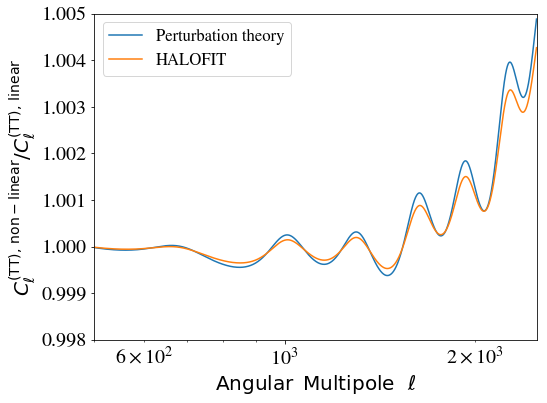

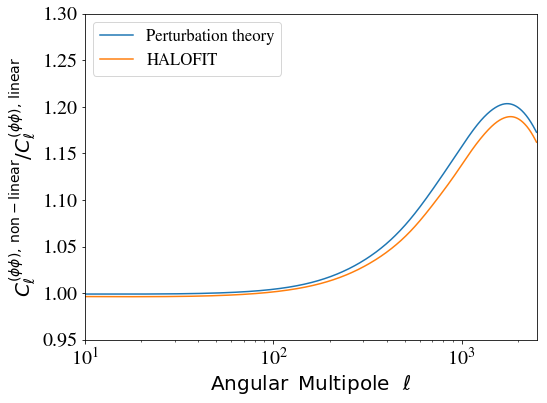

In [8]:
fig_TT, ax_TT = plt.subplots()
ax_TT.semilogx(ll,clTT/clTTlin,linestyle='-',label=r'Perturbation theory')
ax_TT.semilogx(ll,clTThal/clTTlin,linestyle='-',label=r'HALOFIT')
ax_TT.set_xlim([500,2500])
ax_TT.set_ylim([0.998,1.005])
ax_TT.set_xlabel(r'$\mathrm{Angular\,\,\,Multipole} \,\,\,\,  \ell$')
ax_TT.set_ylabel(r'$C_\ell^\mathrm{(TT),\,{\rm non-linear}}/C_\ell^\mathrm{(TT),\,{\rm linear}}$')
ax_TT.legend(loc='upper left')
fig_TT.tight_layout()
fig_TT.savefig('ratios-cltt.pdf')

fig_PP, ax_PP = plt.subplots()
ax_PP.semilogx(ll,clPP/clPPlin,linestyle='-',label=r'Perturbation theory')
ax_PP.semilogx(ll,clPPhal/clPPlin,linestyle='-',label=r'HALOFIT')
ax_PP.set_xlim([10,2500])
ax_PP.set_ylim([0.95,1.3])
ax_PP.set_xlabel(r'$\mathrm{Angular\,\,\,Multipole} \,\,\,\,  \ell$')
ax_PP.set_ylabel(r'$C_\ell^{(\phi \phi),\,{\rm non-linear}}/C_\ell^{(\phi \phi),\,{\rm linear}}$')
ax_PP.legend(loc='upper left')
fig_PP.tight_layout()
fig_PP.savefig('ratios-clpp.pdf')

In [9]:
####################################################
#
# compute power with external linear power spectrum
#
####################################################

# First create an external linear power spectrum (doesn't have to be from CLASS)
# This should be in 1/Mpc units across a wide range of k and for CDM+Baryons

k_vals_invMpc = np.logspace(-4,1,10000) # in 1/Mpc
pk_lin = np.asarray([M.pk_lin(kk,z_pk) for kk in k_vals_invMpc]) # in Mpc^3

# Save to file
external_file = os.getcwd()+'/k_pk_to_interp.dat'
np.savetxt(external_file,np.vstack([k_vals_invMpc,pk_lin]).T,delimiter='\t')
       
# Now load in CLASS with external linear power spectrum and non-linear settings
# NB: This uses CLASS f(z), D_A(z) and H(z) scalings for the RSD / Alcock-Pacyznski calculations
# Custom values for these can be input in the nonlinear_pt.c code (line ~ 1000)
M_ext = Class()
M_ext.set(common_settings)
M_ext.set({'output':'mPk',
        'non linear':'PT',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31',
        'Input Pk':external_file # load in external spectrum here
       })
M_ext.compute()

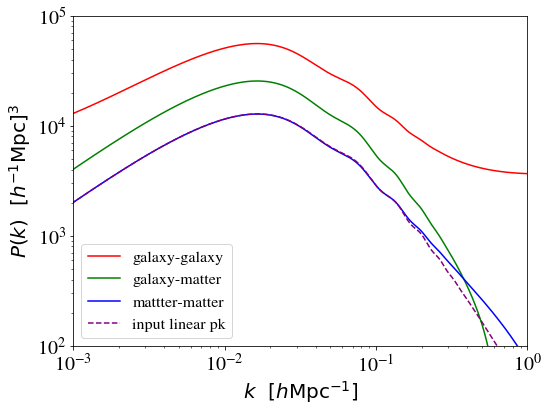

In [10]:
#############################################################################################
#
# extract spectra and plot them using the external Pk rather than the default CLASS one
#
#############################################################################################

h = M_ext.h()
fz = M_ext.scale_independent_growth_factor_f(z_pk)
kvec = np.logspace(-3,np.log10(3),1000) # array of kvec in h/Mpc
twopi = 2.*math.pi
khvec = kvec*h # array of kvec in 1/Mpc
#
# Create figures
#
fig_Pk, ax_Pk = plt.subplots()

# Initialize output wrapper
M_ext.initialize_output(khvec, z_pk, len(khvec))
pk_gg_ext = M_ext.pk_gg_real(b1, b2, bG2, bGamma3, cs, cs0, Pshot)
pk_gm_ext = M_ext.pk_gm_real(b1, b2, bG2, bGamma3, cs, cs0)
pk_mm_ext = M_ext.pk_mm_real(cs)

ax_Pk.loglog(kvec,np.array(pk_gg_ext),color='r',linestyle='-',label='galaxy-galaxy')
ax_Pk.loglog(kvec,np.array(pk_gm_ext),color='g',linestyle='-',label='galaxy-matter')
ax_Pk.loglog(kvec,np.array(pk_mm_ext),color='b',linestyle='-',label='mattter-matter')
ax_Pk.loglog(k_vals_invMpc/h,np.asarray(pk_lin)*h**3.,color='purple',linestyle='--',label='input linear pk')

# output of P(k) figures
ax_Pk.set_xlim([1.e-3,1])
ax_Pk.set_ylim([100,1e5])
ax_Pk.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pk.set_ylabel(r'$P(k)\,\,\,\, [h^{-1}\mathrm{Mpc}]^3$')
ax_Pk.legend(fontsize='16',ncol=1,loc='lower left')
fig_Pk.savefig('external_Pk.pdf')
fig_Pk.tight_layout()